# Collect and process PBMC3K single-cell RNA-seq dataset

**Authorship:**
Adam Klie, *02/15/2022*
***
**Description:**
Notebook to collect data for performing the autoencoder exercise outlined [here](https://www.notion.so/Autoencoder-Workshop-73d10091ac014f8c966a503e02759b11). These steps are specific to preprocessing the data for my implementation of the [Deep Count Autoencoder](https://github.com/theislab/dca/tree/08fc69c367421ddbf4837f6727f57a4b0c585ce2)(DCA) 
***
**Notes:**
 - You will need a kernel with [Scanpy](https://scanpy-tutorials.readthedocs.io/) installed. Follow the below instructions if you would like to build a kernel yourself, or simply use the following environment: `/cellar/users/aklie/opt/miniconda3/envs/single_cell_py` (see the autoencoder exercise instructions for setting up kernel using another user's environment).
 
```bash
conda create -n single_cell_py python=3.6 seaborn scikit-learn statsmodels numba
conda activate single_cell_py
conda install -c conda-forge python-igraph louvain leidenalg
conda install -c conda-forge python-igraph louvain leidenalg
pip install scanpy
pip install ipython ipykernel
python -m ipykernel install --user --name single_cell_py --display-name "Python 3 single_cell"
```
***
**TODO:**
 - <font color="red"> Integrate this with the OG collect and preprocess notebook </font>

# Set-up

In [1]:
# The classics
import numpy as np
import pandas as pd

# Single cell analysis
import scanpy as sc
sc.settings.verbosity = 2
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

scanpy==1.7.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


# PBMC3K w/ `scanpy` API
The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. 
***
The following steps outlined in the [DCA manuscript](https://www.nature.com/articles/s41467-018-07931-2) were followed:

 - Filtering cells with 0 counts
 - Scaling by size factors (median of library size)
 - Log normalization
 - Variable gene selection
 - Z-score (Scaling to 0 mean and 1 standard deviation)

## <u> **Filtering** <u/>
Remove zero expression genes and counts (https://www.nature.com/articles/s41467-018-07931-2#Sec13)

In [7]:
# Load the datasets
pbmc3k = sc.datasets.pbmc3k()

In [8]:
# Remove zero count cells
sc.pp.filter_genes(pbmc3k, min_cells=1)
sc.pp.filter_cells(pbmc3k, min_genes=1)
sc.pp.calculate_qc_metrics(pbmc3k, inplace=True)

filtered out 16104 genes that are detected in less than 1 cells


## <u> **Size factors** <u/>
Formally, we are dividing each cells count by the median of total read counts for all cells. This ensures that total counts are the same across all cells.

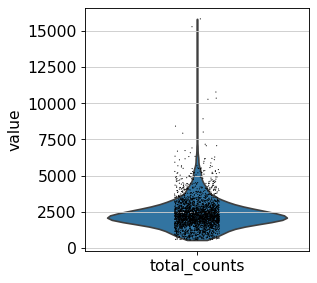

In [9]:
# Check distribution of counts across cells
sc.pl.violin(pbmc3k, keys="total_counts")

In [10]:
# Manually calculate scale factors and save
raw_counts = pbmc3k.X.A
scale_factors = np.sum(raw_counts, axis=1)/np.median(np.sum(raw_counts, axis=1))
np.save("data/pbmc3k_sfs", scale_factors)
manually_scaled = raw_counts.T/scale_factors

In [11]:
# Use scanpy
pbmc3k.layers['counts'] = pbmc3k.X.copy()
sc.pp.normalize_total(pbmc3k, key_added="scale_factor")
pbmc3k.obs["scale_factor"] = pbmc3k.obs["scale_factor"]/pbmc3k.obs["scale_factor"].median()

normalizing counts per cell
    finished (0:00:00)


In [12]:
# Sanity check similarity
print("Scale factors the same?", (pbmc3k.obs["scale_factor"] == scale_factors).all())
print("Normalized values the same?", np.isclose(pbmc3k.X.A.T, manually_scaled).all())

Scale factors the same? True
Normalized values the same? True


## <u> **Normalizing** <u/>
Log transform the scaled counts to stabalize the variance of genes across cells. Also adds a pseudocount.

In [13]:
sc.pp.log1p(pbmc3k)

## <u> **Select Variable Genes** <u/>
Select the most variable genes from our dataset to reduce our feature space. The assumption here is that most of the interesting variation in our datasets is captured in these variable features. The original DCA paper used the top 1000 genes, but here we will use mean and dispersion cut-offs instead.

In [19]:
# ID the most highly variable genes
sc.pp.highly_variable_genes(pbmc3k, min_mean=0.0125, max_mean=3, min_disp=0.5)
pbmc3k.var["highly_variable"].value_counts()

extracting highly variable genes
    finished (0:00:00)


False    14764
True      1870
Name: highly_variable, dtype: int64

## <u> **Scaling** <u/>
Finally, we z-score our data to have unit variance and zero mean. This is done to aid training, as gradients tend to be more stable and consistent when each input feature comes from the same (or similar) distributions.

In [20]:
sc.pp.scale(pbmc3k)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## <u> **Saving** <u/>
We will save multiple formats of the data to allow us to perform some downstream analysis and comparisons to the original DCA!

In [150]:
pbmc3k.write_h5ad("data/pbmc3k_AKprocessed.h5ad")

In [186]:
np.save("data/pbmc3k_norm", pbmc3k[:, pbmc3k.var["highly_variable"]].X)
np.save("data/pbmc3k_counts", pbmc3k[:, pbmc3k.var["highly_variable"]].layers["counts"].A)

In [190]:
np.savetxt("data/pbmc3k_cellids.txt", pbmc3k.obs.index, fmt="%s")

In [21]:
np.savetxt("data/pbmc3k_geneids.txt", pbmc3k[:, pbmc3k.var["highly_variable"]].var.index, fmt="%s")

# References
1. [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing-and-clustering-3k-PBMCs)
2. [Single-cell RNA-seq denoising using a deep count autoencoder](https://www.nature.com/articles/s41467-018-07931-2)
3. [Model-based deep embedding for constrained clustering analysis of single cell RNA-seq data](https://www.nature.com/articles/s41467-021-22008-3)

<div class="alert alert-success" role="alert">
  <h4 class="alert-heading">Well done!</h4>
  <p>You successfully preprocessed your data
  <hr>
  <p class="mb-0">Onto running training a <b>DCA</b> model!</p>
</div>